In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from skrebate import ReliefF
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]

files = [
    ("data/processed.cleveland.data", "cleveland"),
    ("data/processed.hungarian.data", "hungarian"),
    ("data/processed.switzerland.data", "switzerland"),
    ("data/processed.va.data", "va")
]

# Load data with source tracking
dfs = []
for file_path, source in files:
    temp_df = pd.read_csv(file_path, 
                         names=column_names, 
                         na_values='?',
                         header=None)
    temp_df['source'] = source
    dfs.append(temp_df)

df = pd.concat(dfs, ignore_index=True)

# Convert columns to numeric, binarize target
for col in column_names:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# Impute missing values by source with KNNImputer
dfs_imputed = []
for source in df['source'].unique():
    temp = df[df['source'] == source].copy()
    numeric_cols = temp.select_dtypes(include=[np.number]).columns.drop('target')
    n_neighbors = min(5, len(temp) - 1)
    imputer = KNNImputer(n_neighbors=n_neighbors)
    temp[numeric_cols] = imputer.fit_transform(temp[numeric_cols])
    dfs_imputed.append(temp)

df = pd.concat(dfs_imputed, ignore_index=True)

# One-hot encode 'source'
df = pd.get_dummies(df, columns=['source'], prefix='src')

# Separate features and target
X = df.drop('target', axis=1)
y = df['target'].values

# Fill any remaining NaNs with median (just in case)
X = X.fillna(X.median())

# Scale all features BEFORE feature selection (ReliefF requires numeric, scaled data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# For chi2, features must be non-negative; create separate variable for that
X_nonneg = X_scaled - X_scaled.min(axis=0)

selectors = {
    "PCA": PCA(n_components=10),
    "ChiSq": SelectKBest(chi2, k=10),
    "ReliefF": ReliefF(n_features_to_select=10),
    "SyUn": SelectKBest(mutual_info_classif, k=10)
}

model = RandomForestClassifier(random_state=42)
results = {}

for name, selector in selectors.items():
    print(f"\n=== Running pipeline with {name} feature selection ===")
    
    if name == "ChiSq":
        X_selected = selector.fit_transform(X_nonneg, y)
    else:
        X_selected = selector.fit_transform(X_scaled, y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, random_state=42, stratify=y
    )

    # Balance training data with SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Scaling again after resampling
    scaler_inner = StandardScaler()
    X_train_scaled = scaler_inner.fit_transform(X_train_res)
    X_test_scaled = scaler_inner.transform(X_test)

    # Train model
    model.fit(X_train_scaled, y_train_res)

    # Predict and evaluate
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)

    print(f"AUC: {auc:.4f}, Accuracy: {acc:.4f}")
    results[name] = {"AUC": auc, "Accuracy": acc}

print("\nSummary of results:")
for k, v in results.items():
    print(f"{k}: AUC={v['AUC']:.4f}, Accuracy={v['Accuracy']:.4f}")


=== Running pipeline with PCA feature selection ===
AUC: 0.9265, Accuracy: 0.8478

=== Running pipeline with ChiSq feature selection ===
AUC: 0.9105, Accuracy: 0.8315

=== Running pipeline with ReliefF feature selection ===
AUC: 0.9086, Accuracy: 0.8261

=== Running pipeline with SyUn feature selection ===
AUC: 0.9193, Accuracy: 0.8261

Summary of results:
PCA: AUC=0.9265, Accuracy=0.8478
ChiSq: AUC=0.9105, Accuracy=0.8315
ReliefF: AUC=0.9086, Accuracy=0.8261
SyUn: AUC=0.9193, Accuracy=0.8261


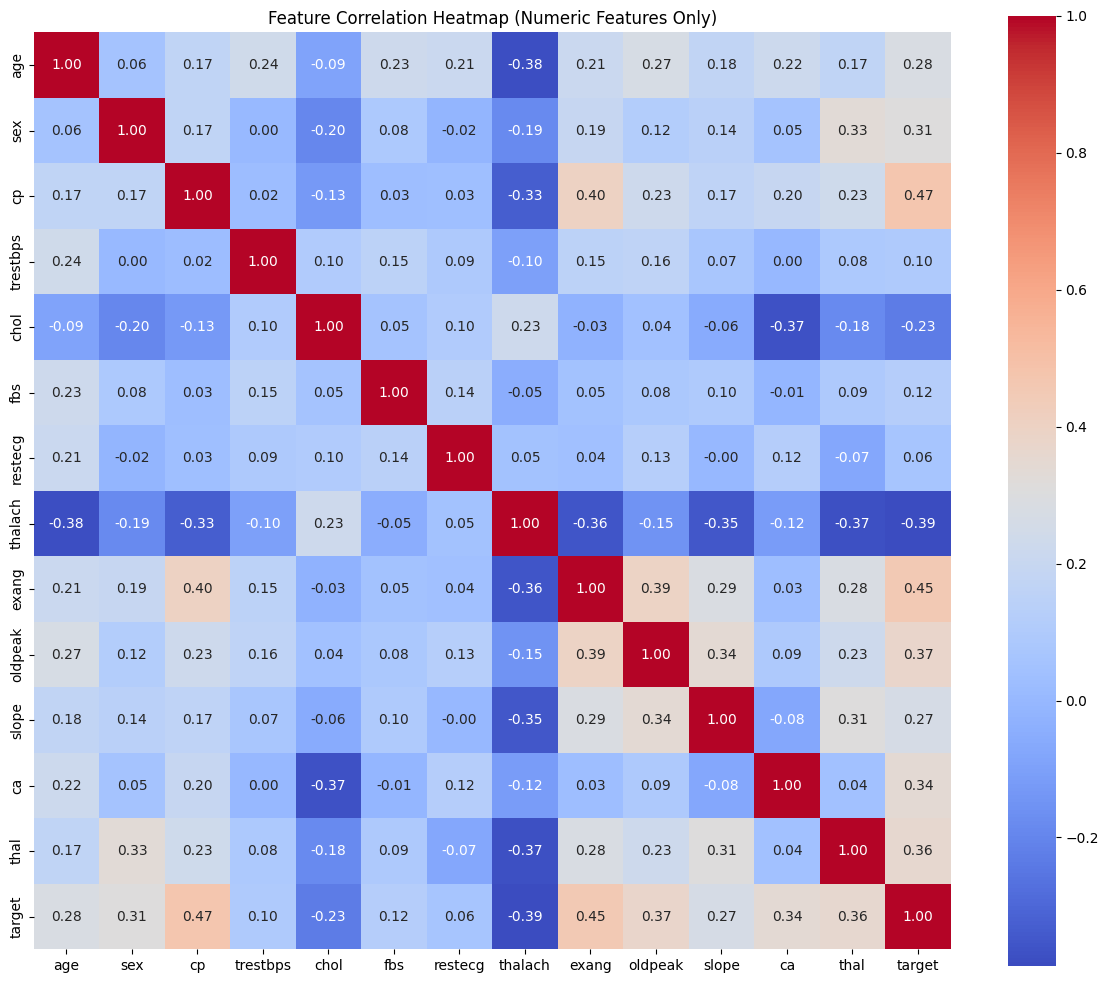

Correlation with target:
target      1.000000
cp          0.471712
exang       0.454343
oldpeak     0.373605
thal        0.359340
ca          0.340599
sex         0.307284
age         0.282700
slope       0.265328
fbs         0.119675
trestbps    0.100005
restecg     0.062807
chol       -0.231038
thalach    -0.387368
Name: target, dtype: float64


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Feature Correlation Heatmap (Numeric Features Only)")
plt.tight_layout()  # Prevent label cutoff
plt.show()

print("Correlation with target:")
print(corr_matrix["target"].sort_values(ascending=False))

In [3]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
)

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from imblearn.over_sampling import SMOTE

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = {}

for fs_name, selector in selectors.items():
    print(f"\n=== Evaluating models with {fs_name} ===")
    results[fs_name] = {}
    
    for model_name, model in models.items():
        # For ChiSq only, you need non-negative features
        if fs_name == "ChiSq":
            input_data = X_nonneg
        else:
            input_data = X_scaled

        pipe = Pipeline([
            ('selector', selector),
            ('smote', SMOTE(random_state=42)),
            ('clf', model)
        ])

        scores = cross_validate(
            pipe, input_data, y,
            cv=cv,
            scoring=scoring,
            return_train_score=False,
            n_jobs=-1
        )

        results[fs_name][model_name] = {
            metric: (scores[f'test_{metric}'].mean(), scores[f'test_{metric}'].std())
            for metric in scoring
        }

for fs_name, fs_results in results.items():
    print(f"\n=== Results for {fs_name} ===")
    for model_name, metrics in fs_results.items():
        print(f"\nModel: {model_name}")
        for metric, (mean, std) in metrics.items():
            print(f"{metric:<10}: {mean:.4f} ± {std:.4f}")


# from sklearn.preprocessing import StandardScaler

# # models
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier

# # evaluation metrics
# from sklearn.metrics import (
#     accuracy_score,
#     precision_score,
#     recall_score,
#     f1_score,
#     confusion_matrix,
#     roc_auc_score,
#     classification_report,
# )

# from sklearn.model_selection import StratifiedKFold, cross_validate
# from imblearn.pipeline import make_pipeline
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from sklearn.preprocessing import StandardScaler


# # your models dict from before
# models = {
#     "Logistic Regression": LogisticRegression(),
#     "Decision Tree": DecisionTreeClassifier(),
#     "Random Forest": RandomForestClassifier(),
#     "SVM": SVC(probability=True),
#     "KNN": KNeighborsClassifier(),
#     "XGBoost": XGBClassifier(eval_metric='logloss')
# }

# pipelines = {}
# for name, model in models.items():
#     if name == "XGBoost":
#         #  TODO: xgboost needs more polish for better results
#         # For XGBoost, no StandardScaler
#         pipelines[name] = Pipeline([
#             ("smote", SMOTE(random_state=42)),
#             ("xgb", model)
#         ])
#     else:
#         # For others, use StandardScaler + SMOTE
#         pipelines[name] = make_pipeline(
#             StandardScaler(),
#             SMOTE(random_state=42),
#             model
#         )

# # 10-fold stratified CV
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

# results = {}
# for name, pipe in pipelines.items():
#     cv_res = cross_validate(
#         pipe,
#         X, y,
#         cv=cv,
#         scoring=scoring,
#         return_train_score=False,
#         n_jobs=-1
#     )
#     # compute mean ± std for each metric
#     summary = {
#         metric: (cv_res[f"test_{metric}"].mean(), cv_res[f"test_{metric}"].std())
#         for metric in scoring
#     }
#     results[name] = summary

# # Flatten results dict
# flat_results = {}
# for model_name, metrics in results.items():
#     flat_metrics = {}
#     for metric, (mean, std) in metrics.items():
#         flat_metrics[f"{metric}_mean"] = mean
#         flat_metrics[f"{metric}_std"] = std
#     flat_results[model_name] = flat_metrics

# # Create DataFrame
# df = pd.DataFrame(flat_results).T

# # Sort by ROC AUC mean
# df = df.sort_values("roc_auc_mean", ascending=False)

# # Round for readability
# print(df.round(4))


=== Evaluating models with PCA ===

=== Evaluating models with ChiSq ===

=== Evaluating models with ReliefF ===

=== Evaluating models with SyUn ===

=== Results for PCA ===

Model: Logistic Regression
accuracy  : 0.8283 ± 0.0350
precision : 0.8526 ± 0.0358
recall    : 0.8350 ± 0.0448
f1        : 0.8431 ± 0.0328
roc_auc   : 0.8970 ± 0.0335

Model: Decision Tree
accuracy  : 0.7511 ± 0.0245
precision : 0.7756 ± 0.0270
recall    : 0.7760 ± 0.0522
f1        : 0.7746 ± 0.0269
roc_auc   : 0.7481 ± 0.0235

Model: Random Forest
accuracy  : 0.8152 ± 0.0461
precision : 0.8269 ± 0.0396
recall    : 0.8428 ± 0.0575
f1        : 0.8341 ± 0.0442
roc_auc   : 0.8931 ± 0.0293

Model: SVM
accuracy  : 0.8207 ± 0.0371
precision : 0.8362 ± 0.0274
recall    : 0.8409 ± 0.0596
f1        : 0.8376 ± 0.0384
roc_auc   : 0.8968 ± 0.0320

Model: KNN
accuracy  : 0.8239 ± 0.0363
precision : 0.8507 ± 0.0290
recall    : 0.8271 ± 0.0538
f1        : 0.8380 ± 0.0360
roc_auc   : 0.8742 ± 0.0343

Model: XGBoost
accuracy  : 

In [4]:
import pandas as pd

results = {
    'Logistic Regression': {
        'Accuracy': 0.8667,
        'Precision': 0.8333,
        'Recall': 0.8333,
        'F1 Score': 0.8333,
        'ROC AUC': 0.9421
    },
    'Decision Tree': {
        'Accuracy': 0.8167,
        'Precision': 0.7407,
        'Recall': 0.8333,
        'F1 Score': 0.7843,
        'ROC AUC': 0.8194
    },
    'Random Forest': {
        'Accuracy': 0.8833,
        'Precision': 0.84,
        'Recall': 0.875,
        'F1 Score': 0.8571,
        'ROC AUC': 0.9404
    },
    'SVM': {
        'Accuracy': 0.8833,
        'Precision': 0.8696,
        'Recall': 0.8333,
        'F1 Score': 0.8511,
        'ROC AUC': 0.9537
    },
    'KNN': {
        'Accuracy': 0.8333,
        'Precision': 0.8182,
        'Recall': 0.75,
        'F1 Score': 0.7826,
        'ROC AUC': 0.9398
    },
    'XGBoost': {
        'Accuracy': 0.8333,
        'Precision': 0.75,
        'Recall': 0.875,
        'F1 Score': 0.8077,
        'ROC AUC': 0.8947
    },
}

df = pd.DataFrame(results).T
df = df.sort_values(by='F1 Score', ascending=False)
print(df)

                     Accuracy  Precision  Recall  F1 Score  ROC AUC
Random Forest          0.8833     0.8400  0.8750    0.8571   0.9404
SVM                    0.8833     0.8696  0.8333    0.8511   0.9537
Logistic Regression    0.8667     0.8333  0.8333    0.8333   0.9421
XGBoost                0.8333     0.7500  0.8750    0.8077   0.8947
Decision Tree          0.8167     0.7407  0.8333    0.7843   0.8194
KNN                    0.8333     0.8182  0.7500    0.7826   0.9398


In [5]:
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('dt', DecisionTreeClassifier()),
        ('rf', RandomForestClassifier()),
        ('svm', SVC(probability=True)),
        ('knn', KNeighborsClassifier()),
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ],
    voting='soft'
)

# train/test split once
X_tr_full, X_te_full, y_tr, y_te = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

for name, selector in selectors.items():
    print(f"\n=== Voting with {name} features ===")
    
    # choose the right input for ChiSq
    if name == "ChiSq":
        X_tr, X_te, y_tr, y_te = train_test_split(
            X_nonneg, y, test_size=0.2, random_state=42, stratify=y
        )
    else:
        X_tr, X_te = X_tr_full, X_te_full
    
    # build pipeline
    pipe = Pipeline([
        ('selector', selector),
        ('smote', SMOTE(random_state=42)),
        ('voting', voting)
    ])

    # fit & predict
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)
    y_proba = pipe.predict_proba(X_te)[:, 1]

    # report
    print("Accuracy: ", accuracy_score(y_te, y_pred))
    print("Precision:", precision_score(y_te, y_pred))
    print("Recall:   ", recall_score(y_te, y_pred))
    print("F1 Score: ", f1_score(y_te, y_pred))
    print("ROC AUC:  ", roc_auc_score(y_te, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred))
    print("Classification Report:\n", classification_report(y_te, y_pred))

# voting_clf = VotingClassifier(
#     estimators=[
#         ('lr', LogisticRegression()),
#         ('dt', DecisionTreeClassifier()),
#         ('rf', RandomForestClassifier()),
#         ('svm', SVC(probability=True)),
#         ('knn', KNeighborsClassifier()),
#         ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
#     ],
#     voting='soft'  # use 'hard' for label-based voting
# )

# voting_clf.fit(X_train, y_train)
# y_pred = voting_clf.predict(X_test)
# y_proba = voting_clf.predict_proba(X_test)[:, 1]

# print("\n=== Voting Classifier (Soft Voting) ===")
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Precision:", precision_score(y_test, y_pred))
# print("Recall:", recall_score(y_test, y_pred))
# print("F1 Score:", f1_score(y_test, y_pred))
# print("ROC AUC:", roc_auc_score(y_test, y_proba))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))


=== Voting with PCA features ===


/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:37:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy:  0.8641304347826086
Precision: 0.8737864077669902
Recall:    0.8823529411764706
F1 Score:  0.8780487804878049
ROC AUC:   0.9203730272596844
Confusion Matrix:
 [[69 13]
 [12 90]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85        82
           1       0.87      0.88      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184


=== Voting with ChiSq features ===


/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:37:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy:  0.8478260869565217
Precision: 0.8627450980392157
Recall:    0.8627450980392157
F1 Score:  0.8627450980392157
ROC AUC:   0.920791487326638
Confusion Matrix:
 [[68 14]
 [14 88]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        82
           1       0.86      0.86      0.86       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184


=== Voting with ReliefF features ===


/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:37:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy:  0.8641304347826086
Precision: 0.8888888888888888
Recall:    0.8627450980392157
F1 Score:  0.8756218905472637
ROC AUC:   0.9137972262075562
Confusion Matrix:
 [[71 11]
 [14 88]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85        82
           1       0.89      0.86      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184


=== Voting with SyUn features ===


/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:37:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy:  0.8478260869565217
Precision: 0.8627450980392157
Recall:    0.8627450980392157
F1 Score:  0.8627450980392157
ROC AUC:   0.9190578670492588
Confusion Matrix:
 [[68 14]
 [14 88]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        82
           1       0.86      0.86      0.86       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



In [6]:
from sklearn.ensemble import StackingClassifier

base_learners = [
    ('lr', LogisticRegression()),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('svm', SVC(probability=True)),
    ('knn', KNeighborsClassifier()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

stacking = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(),
    passthrough=True,
    cv=5
)

for name, selector in selectors.items():
    print(f"\n=== Stacking with {name} features ===")
    
    if name == "ChiSq":
        X_tr, X_te, y_tr, y_te = train_test_split(
            X_nonneg, y, test_size=0.2, random_state=42, stratify=y
        )
    else:
        X_tr, X_te, y_tr, y_te = X_tr_full, X_te_full, y_tr, y_te

    pipe = Pipeline([
        ('selector', selector),
        ('smote', SMOTE(random_state=42)),
        ('stacking', stacking)
    ])

    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)
    y_proba = pipe.predict_proba(X_te)[:, 1]

    print("Accuracy: ", accuracy_score(y_te, y_pred))
    print("Precision:", precision_score(y_te, y_pred))
    print("Recall:   ", recall_score(y_te, y_pred))
    print("F1 Score: ", f1_score(y_te, y_pred))
    print("ROC AUC:  ", roc_auc_score(y_te, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred))
    print("Classification Report:\n", classification_report(y_te, y_pred))

# from sklearn.ensemble import StackingClassifier

# base_learners = [
#     ('lr', LogisticRegression()),
#     ('dt', DecisionTreeClassifier()),
#     ('rf', RandomForestClassifier()),
#     ('svm', SVC(probability=True)),
#     ('knn', KNeighborsClassifier()),
#     ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
# ]

# stacking_clf = StackingClassifier(
#     estimators=base_learners,
#     final_estimator=LogisticRegression(),
#     passthrough=True,  # include original features for meta model
#     cv=5
# )

# stacking_clf.fit(X_train, y_train)
# y_pred = stacking_clf.predict(X_test)
# y_proba = stacking_clf.predict_proba(X_test)[:, 1]

# print("\n=== Stacking Classifier ===")
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Precision:", precision_score(y_test, y_pred))
# print("Recall:", recall_score(y_test, y_pred))
# print("F1 Score:", f1_score(y_test, y_pred))
# print("ROC AUC:", roc_auc_score(y_test, y_proba))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))


=== Stacking with PCA features ===


/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:37:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:37:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:37:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy:  0.8586956521739131
Precision: 0.88
Recall:    0.8627450980392157
F1 Score:  0.8712871287128713
ROC AUC:   0.9246771879483501
Confusion Matrix:
 [[70 12]
 [14 88]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84        82
           1       0.88      0.86      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184


=== Stacking with ChiSq features ===


/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:37:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:37:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:37:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy:  0.8532608695652174
Precision: 0.8712871287128713
Recall:    0.8627450980392157
F1 Score:  0.8669950738916257
ROC AUC:   0.9145743663318987
Confusion Matrix:
 [[69 13]
 [14 88]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.84        82
           1       0.87      0.86      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184


=== Stacking with ReliefF features ===


/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:37:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:37:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:37:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy:  0.8695652173913043
Precision: 0.8979591836734694
Recall:    0.8627450980392157
F1 Score:  0.88
ROC AUC:   0.9182209469153515
Confusion Matrix:
 [[72 10]
 [14 88]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86        82
           1       0.90      0.86      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184


=== Stacking with SyUn features ===


/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:37:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:37:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy:  0.8206521739130435
Precision: 0.8556701030927835
Recall:    0.8137254901960784
F1 Score:  0.8341708542713567
ROC AUC:   0.9131994261119082
Confusion Matrix:
 [[68 14]
 [19 83]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.80        82
           1       0.86      0.81      0.83       102

    accuracy                           0.82       184
   macro avg       0.82      0.82      0.82       184
weighted avg       0.82      0.82      0.82       184



In [7]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import (RandomizedSearchCV, cross_val_score, StratifiedKFold)

# define parameter grids
rf_param = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2,5,10]
}
xgb_param = {
    "n_estimators": [50,100,200],
    "max_depth": [3,5,7],
    "learning_rate": [0.01,0.1,0.2]
}

# outer CV (for CI)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# inner CV + random search
def nested_score(model, param_grid):
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    search = RandomizedSearchCV(
        model, param_distributions=param_grid,
        n_iter=10, scoring="roc_auc", cv=inner_cv,
        random_state=42, n_jobs=-1
    )
    scores = cross_val_score(search, X, y,
                             scoring="roc_auc",
                             cv=outer_cv, n_jobs=-1)
    print(f"{model.__class__.__name__}: {scores.mean():.3f} ± {scores.std():.3f}")

nested_score(RandomForestClassifier(random_state=42), rf_param)
nested_score(XGBClassifier(eval_metric="logloss", random_state=42), xgb_param)

RandomForestClassifier: 0.899 ± 0.021
XGBClassifier: 0.897 ± 0.021


Epoch 1/30
19/19 - 7s - 358ms/step - AUC: 0.8067 - loss: 0.7303 - val_AUC: 0.8688 - val_loss: 0.6838 - learning_rate: 1.0000e-03
Epoch 2/30
19/19 - 0s - 13ms/step - AUC: 0.8788 - loss: 0.6318 - val_AUC: 0.8767 - val_loss: 0.5783 - learning_rate: 1.0000e-03
Epoch 3/30
19/19 - 0s - 11ms/step - AUC: 0.8868 - loss: 0.5378 - val_AUC: 0.8812 - val_loss: 0.5090 - learning_rate: 1.0000e-03
Epoch 4/30
19/19 - 0s - 13ms/step - AUC: 0.8950 - loss: 0.4902 - val_AUC: 0.8823 - val_loss: 0.5043 - learning_rate: 1.0000e-03
Epoch 5/30
19/19 - 0s - 15ms/step - AUC: 0.8981 - loss: 0.4808 - val_AUC: 0.8827 - val_loss: 0.5008 - learning_rate: 1.0000e-03
Epoch 6/30
19/19 - 0s - 12ms/step - AUC: 0.8926 - loss: 0.4840 - val_AUC: 0.8868 - val_loss: 0.4894 - learning_rate: 1.0000e-03
Epoch 7/30
19/19 - 0s - 17ms/step - AUC: 0.9039 - loss: 0.4615 - val_AUC: 0.8864 - val_loss: 0.4906 - learning_rate: 1.0000e-03
Epoch 8/30
19/19 - 0s - 9ms/step - AUC: 0.9038 - loss: 0.4601 - val_AUC: 0.8876 - val_loss: 0.4878 - le

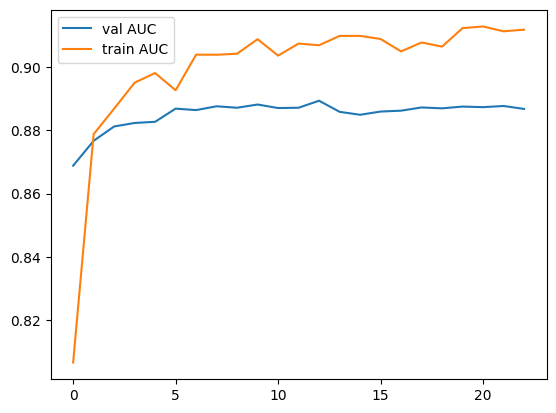

In [9]:
from keras import layers, models, regularizers, callbacks, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing - scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled, y_train.astype(np.float32),
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

def build_encoder(input_dim):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(64, activation="swish", kernel_regularizer=regularizers.l2(1e-3))(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation="swish", kernel_regularizer=regularizers.l2(1e-3))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(16, activation="swish", kernel_regularizer=regularizers.l2(1e-3))(x)
    return models.Model(inp, x)

encoder = build_encoder(X_tr.shape[1])

head_in = layers.Input(shape=(16,))
x = layers.Dense(8, activation="swish")(head_in)
out = layers.Dense(1, activation="sigmoid")(x)
head = models.Model(head_in, out)

inp = encoder.input
logit = head(encoder.output)
model = models.Model(inp, logit)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["AUC"]
)

early_stop = callbacks.EarlyStopping(monitor='val_AUC', patience=10, mode='max', restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_AUC', factor=0.5, patience=5, min_lr=1e-6, mode='max')

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

dl_train_preds = model.predict(X_train_scaled)
dl_val_preds = model.predict(X_val)

plt.plot(history.history["val_AUC"], label="val AUC")
plt.plot(history.history["AUC"], label="train AUC")
plt.legend()
plt.show()

`VIF` stands for Variance Inflation Factor, a diagnostic tool used in regression analysis to detect multicollinearity among independent variables.

Multicollinearity occurs when one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy. This messes with your estimates of coefficients — making them unstable and inflating their variances.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''